In [1]:
# Import dependencies
import numpy as np
import tensorflow as tf
import pandas as pd  # For playing with CSV files
import helper_functions.utils as utils  # Write any function here
from My_model import *  # To import the model class
from matplotlib import pyplot as plt  # To plot graphs
# I used it to split dataset into Train-Dev-Test sets
from sklearn import model_selection as skMS

In [2]:
# Import the data
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

In [3]:
# Change categorical symbols to numerical-like data
for df in [train_df, test_df]:
    
    df['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2}, inplace=True)
    df['Sex'].replace({'male': 0, 'female': 1}, inplace=True)

# Replace NaN with mean values
train_df['Age'] = train_df['Age'].fillna(26.3)
test_df['Age'] = test_df['Age'].fillna(26.3)
train_df['Fare'] = train_df['Fare'].fillna(32.2)
test_df['Fare'] = test_df['Fare'].fillna(32.2)
train_df['Embarked'] = train_df['Embarked'].fillna(0)
test_df['Embarked'] = test_df['Embarked'].fillna(0)

            AgeBand  Survived
0    (0.34, 26.947]  0.366935
1  (26.947, 53.473]  0.417391
2    (53.473, 80.0]  0.320000
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex  Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  0.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  1.0      1      0   
2                             Heikkinen, Miss. Laina    1  0.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  1.0      1      0   
4                           Allen, Mr. William Henry    0  1.0      0      0   

             Ticket     Fare Cabin  Embarked           AgeBand  
0         A/5 21171   7.2500   NaN       0.0    (0.34, 26.947]  
1          PC 17599  71.2833   C85       1.0  (26.94

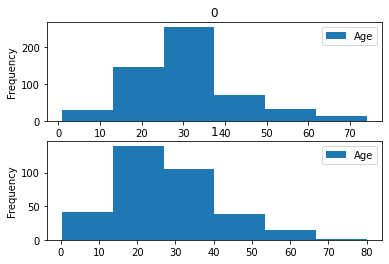

In [4]:
# Study age and categorize it into bands
train_df.get(['Age','Survived']).plot.hist(by='Survived', bins=6)
train_df['AgeBand'] = pd.cut(train_df['Age'], 3)
print(train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True))

for df in [train_df, test_df]:
    
    df.loc[ df['Age'] <= 27, 'Age'] = 0
    df.loc[(df['Age'] > 27) & (df['Age'] <= 60), 'Age'] = 1
    df.loc[ df['Age'] > 60, 'Age'] = 2

print(train_df.head())



In [5]:
# Drop AgeBand column
train_df = train_df.drop(columns=['AgeBand'])

             FareBand  Survived
0   (-0.512, 170.776]  0.376579
1  (170.776, 341.553]  0.647059
2  (341.553, 512.329]  1.000000
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex  Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  0.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  1.0      1      0   
2                             Heikkinen, Miss. Laina    1  0.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  1.0      1      0   
4                           Allen, Mr. William Henry    0  1.0      0      0   

             Ticket  Fare Cabin  Embarked           FareBand  
0         A/5 21171   0.0   NaN       0.0  (-0.512, 170.776]  
1          PC 17599   0.0   C85       1.0  (-0.5

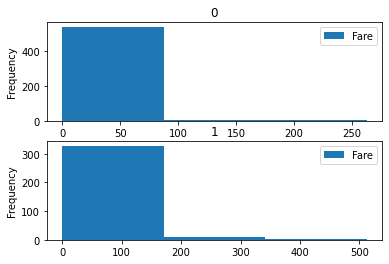

In [6]:
# Categorizing Fare
# Study Fare and categorize it into bands
train_df.get(['Fare','Survived']).plot.hist(by='Survived', bins=3)
train_df['FareBand'] = pd.cut(train_df['Fare'], 3)
print(train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True))

for df in [train_df, test_df]:
    
    df.loc[ df['Fare'] <= 170, 'Fare'] = 0
    df.loc[(df['Fare'] > 170) & (df['Fare'] <= 340), 'Fare'] = 1
    df.loc[ df['Fare'] > 340, 'Fare'] = 2

print(train_df.head())

In [7]:
# Drop FareBand column
train_df = train_df.drop(columns=['FareBand'])

In [8]:
# Drop unused features

train_df = train_df.drop(columns=['PassengerId', 'Name', 'Cabin', 'Ticket'])
test_df = test_df.drop(columns=['PassengerId', 'Name', 'Cabin', 'Ticket'])

y = train_df['Survived'].values  # This is the outputs of the training data
train_df = train_df.drop(columns=['Survived'])  # Drop the outputs from the inputs
X = train_df.values  # Prepared inputs into numpy array

train_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,0.0,1,0,0.0,0.0
1,1,1,1.0,1,0,0.0,1.0
2,3,1,0.0,0,0,0.0,0.0
3,1,1,1.0,1,0,0.0,0.0
4,3,0,1.0,0,0,0.0,0.0


In [9]:
# Splitting dataset into train_set and dev_set
"""X_train, X_dev, y_train, y_dev = skMS.train_test_split(X, y, test_size=0.2)
X_dev, X_test, y_dev, y_test = skMS.train_test_split(
    X_dev, y_dev, test_size=0.5)"""

X_train, X_test, y_train, y_test = skMS.train_test_split(X, y, test_size=0.1)

In [10]:
model = My_Model()
print(model.summary())
model.compile(optimizer="adam",
              loss="mse",
              metrics=["mae"])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                256       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
hist = model.fit(
    x=X_train,
    y=y_train,
    batch_size=None,
    epochs=200,
    verbose='auto',
    callbacks=None,
    validation_split=0.1,
    #validation_data=(X_dev, y_dev),
    shuffle=True,
    class_weight=None,
    # sample_weight=weights_train,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

Epoch 1/200
23/23 [==============================] - 1s 6ms/step - loss: 0.2342 - mae: 0.4438 - val_loss: 0.1982 - val_mae: 0.4246
Epoch 2/200
23/23 [==============================] - 0s 3ms/step - loss: 0.2108 - mae: 0.4382 - val_loss: 0.1846 - val_mae: 0.4139
Epoch 3/200
23/23 [==============================] - 0s 3ms/step - loss: 0.1940 - mae: 0.4188 - val_loss: 0.1731 - val_mae: 0.3965
Epoch 4/200
23/23 [==============================] - 0s 3ms/step - loss: 0.1812 - mae: 0.4027 - val_loss: 0.1664 - val_mae: 0.3851
Epoch 5/200
23/23 [==============================] - 0s 3ms/step - loss: 0.1726 - mae: 0.3880 - val_loss: 0.1609 - val_mae: 0.3733
Epoch 6/200
23/23 [==============================] - 0s 3ms/step - loss: 0.1654 - mae: 0.3753 - val_loss: 0.1558 - val_mae: 0.3620
Epoch 7/200
23/23 [==============================] - 0s 3ms/step - loss: 0.1605 - mae: 0.3621 - val_loss: 0.1518 - val_mae: 0.3521
Epoch 8/200
23/23 [==============================] - 0s 3ms/step - loss: 0.1566 - m

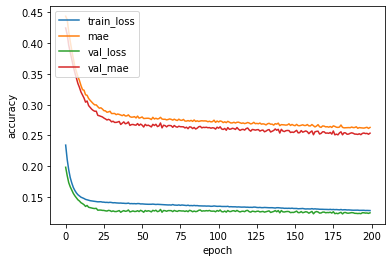

{'loss': 0.14940570294857025, 'mae': 0.28705981373786926}


In [12]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['val_mae'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss', 'mae', 'val_loss', 'val_mae'], loc='upper left')
plt.show()

print(model.evaluate(X_test, y_test, verbose='auto', return_dict=True))

In [13]:
model.save(
    'Titanic_model',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

INFO:tensorflow:Assets written to: Titanic_model\assets


In [14]:
model = tf.keras.models.load_model('Titanic_model')
model.summary()
X_test_sub = test_df.values

Preds = model.predict(X_test_sub)
Predictions = []

for pred in range(0, len(Preds)):
    if (Preds[pred] >= 0.5):
        Predictions.append(1)
    else:
        Predictions.append(0)

data = {'PassengerId': df['PassengerId'].values, 'Survived': Predictions}
df_submission = pd.DataFrame(data=data)
df_submission.to_csv(path_or_buf='submission.csv', index=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                256       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
